# Deep Learning Project
## Buid a Digit Recognition Program

In this project, we will design and implment svm model and deep learning model that learns to recognize sequences of digits. We will train the model using synthetic data generated by concatenating character images from [Optdigits](https://datahub.io/machine-learning/optdigits).

The files have handwriting gray digit images (65 columns each). Each row stores one digit image that has been reshaped from an 8 × 8 array. We will build a deep learning model to predict the digit from a test image. Different digits have different number of images in the data.

### Implementation
Let's start by importing the modules we'll require fot this project.

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [79]:
X_train = pd.read_csv('optdigits.tra',header=None) 
X_test  = pd.read_csv('optdigits.tes',header=None)

#Target variable in column 64
y_train = X_train[64]
y_test  = X_test[64]

X_train = X_train.drop(X_train.columns[64],axis=1)
X_test  = X_test.drop(X_test.columns[64],axis=1)

In [80]:
print("Shape of training dataset: {}".format(np.shape(X_train)))
print("Shape of test dataset: {}".format(np.shape(X_test)))

Shape of training dataset: (3823, 64)
Shape of test dataset: (1797, 64)


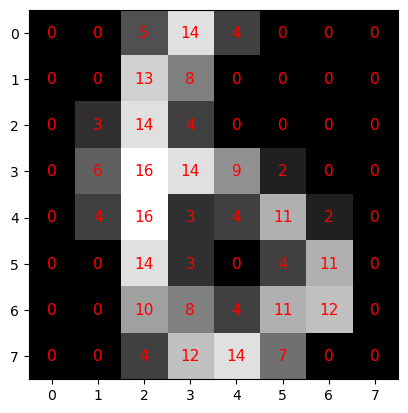

In [81]:
pixels = X_train.values[4].reshape(8,8)
plt.imshow(pixels,cmap='gray')
# add red label on each pixel
for i in range(8):
    for j in range(8):
        text = plt.text(j, i, pixels[i,j], 
                        ha="center", 
                        va="center", 
                        color="r",
                        fontsize = 11)

We add the red label to each pixel. Based on the observation, we find that 0 is black pixel and the 16 is the white pixel. Before we start to build the model, we are going to see the first 9 digits in the train set.
### SVM Model Building
We're going to use a Support Vector Classfication to build a model. We will see how the model performance going and we will continue improve the model by using cross-vakidation to find the best c and gamma value.

In [82]:
list(y_train[:9])

[0, 0, 7, 4, 6, 2, 5, 5, 0]

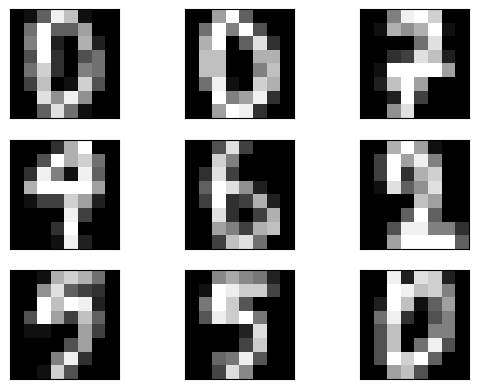

In [83]:
for k in range(0,9):
    image = X_train.values[k].reshape(8,8)    
    ax = plt.subplot(3,3,k+1)
    ax.imshow(image,cmap='gray')
    plt.setp(ax,xticks=[], yticks=[])

In [84]:
svc = SVC(kernel = 'linear')
svc.fit(X_train,y_train);

In [85]:
# test accuracy rate
ypred = svc.predict(X_test)
acc1 = accuracy_score(y_test,ypred)
print('The test accuracy rate:{acc1}')

The test accuracy rate:{acc1}


In [86]:
df1 = pd.crosstab(y_test,ypred,
                  rownames=['true labels'],
                  colnames=['predictions'])

In [87]:
df2 = df1.copy()
df2['row sum'] = df2.sum(axis=1).values

df2['error rate'] = 1-np.diag(df1)/np.sum(df1,axis=1)
del df2['row sum']
df2

predictions,0,1,2,3,4,5,6,7,8,9,error rate
true labels,,,,,,,,,,,
0,177,0,0,0,0,1,0,0,0,0,0.005618
1,0,178,0,0,0,0,3,0,1,0,0.021978
2,0,7,170,0,0,0,0,0,0,0,0.039548
3,1,0,5,171,0,2,0,2,1,1,0.065574
4,0,0,0,0,180,0,0,0,1,0,0.005525
5,0,0,1,0,0,180,0,0,0,1,0.010989
6,0,0,0,0,1,0,179,0,1,0,0.011050
7,0,0,0,0,1,7,0,165,0,6,0.078212
8,0,9,1,5,0,2,0,0,157,0,0.097701


In [88]:
# digit with largest error rate
df2[ df2['error rate']==df2['error rate'].max()]

predictions,0,1,2,3,4,5,6,7,8,9,error rate
true labels,,,,,,,,,,,
8,0,9,1,5,0,2,0,0,157,0,0.097701


### Find the best C and gamma

In [89]:
kfold = StratifiedKFold(n_splits=5,
                        shuffle = True, 
                        random_state = 1)

params = {'C': [0.001, 0.01, 0.1, 1, 10],
          'gamma': [0.001, 0.01, 0.1, 1, 10]}

grid_search = GridSearchCV(SVC(), params, cv=kfold)
grid_search.fit(X_train, y_train);

In [90]:
grid_search.best_params_

{'C': 10, 'gamma': 0.001}

In [91]:
# Validation accuracy rate
grid_search.best_score_

0.991368442665024

In [92]:
# Test accuracy rate
grid_search.score(X_test, y_test)

0.9827490261547023

### Heatmap on the GridSearchCV

In [93]:
# store the results into a Dataframe
results = pd.DataFrame(grid_search.cv_results_)
results.dtypes

# Create a dataframe with selected columns
list1 = list([4,5,12])
df9 = results.iloc[:,list1].copy()
df9.columns = ['C','gamma','arate']
df9

# Show validation accuracy rates in a two-way table
df1 = df9.pivot_table('arate',columns = 'C',index = 'gamma')
df1

# Transform dataframe into array
arates = df1.values
arates = np.round(arates,3)
arates

array([[0.161, 0.789, 0.977, 0.989, 0.991],
       [0.147, 0.147, 0.151, 0.832, 0.845],
       [0.102, 0.102, 0.102, 0.107, 0.107],
       [0.162, 0.162, 0.162, 0.102, 0.102],
       [0.103, 0.103, 0.103, 0.103, 0.103]])

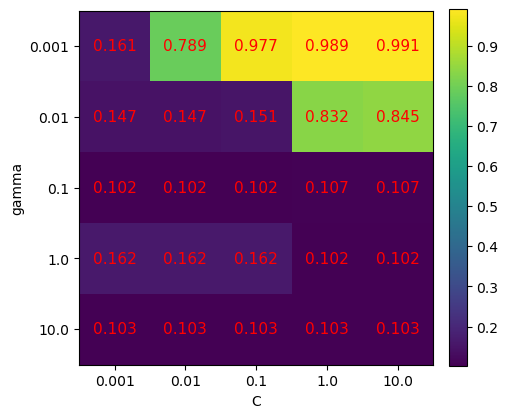

In [94]:
plt.figure(figsize = (5,5))
plt.yticks(range(5),df1.index)
plt.xticks(range(5),df1.columns)
plt.ylabel('gamma')
plt.xlabel('C')
plt.imshow(arates)
for i in range(5):
    for j in range(5):
        text = plt.text(j, i, arates[i,j], 
                        ha="center", 
                        va="center", 
                        color="r",
                        fontsize = 11)
# resize colorbar
plt.colorbar(fraction=0.046, pad=0.04);

### Deep Learning Model Building

We're going to use a Tensorflow for our network.

Starting with with 2 hidden layers with 24 nodes and activation relu and the output layer with 10 nodes and activation softmax

In [95]:
from tensorflow.keras.utils import to_categorical
X_train = pd.read_csv('optdigits.tra',header=None)
X_test  = pd.read_csv('optdigits.tes',header=None)
y_train = X_train[64]
y_test  = X_test[64]
X_train = X_train.drop(X_train.columns[64],axis=1)
X_test  = X_test.drop(X_test.columns[64],axis=1)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [96]:
network2 = keras.Sequential([
    layers.Dense(24, activation='relu'),
    layers.Dense(24, activation='relu'),
    layers.Dense(10, activation='softmax') 
])
network2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
history2 = network2.fit(X_train, 
                        y_train,
                        epochs=1100, 
                        batch_size = 48,
                        validation_split = 0.20, 
                        verbose = 0)

history_dict = history2.history
history_dict.keys()
df3 = pd.DataFrame(history_dict)
df3

,loss,accuracy,val_loss,val_accuracy
0,2.279401,0.163833,2.250419,0.260131
1,2.215620,0.264879,2.163819,0.325490
2,2.104275,0.337148,2.023331,0.347712
3,1.943159,0.394702,1.841650,0.448366
4,1.747568,0.524853,1.641107,0.559477
...,...,...,...,...
1095,0.000194,1.000000,0.198061,0.977778
1096,0.000158,1.000000,0.196484,0.976471
1097,0.000203,1.000000,0.194177,0.975163
1098,0.000177,1.000000,0.197827,0.977778


After we build out the model, we're going to plot the train and validation loss curves to see how many epochs does the model start overfitting (as soon as the curves stop decreasing)? And then we will retrain the model with this number of epochs (same batch-size).

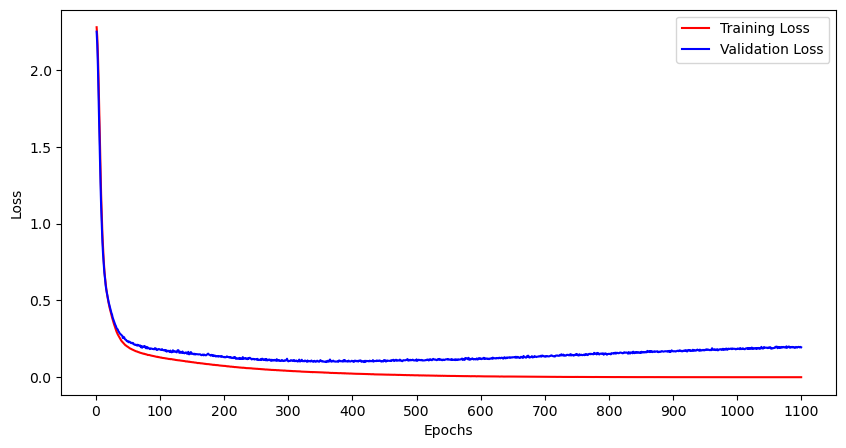

In [97]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1,1101)

plt.figure(figsize=(10,5))
plt.plot(epochs,loss_values,'r',label='Training Loss')
plt.plot(epochs,val_loss_values,'b',label='Validation Loss')
plt.xticks(range(0,1150, 100))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [98]:
oepoch3=df3[df3.val_loss==df3.val_loss.min()].index[0]
print(f'At epoch {oepoch3}, the model starts to overfit.')

history3=network2.fit(X_train, 
                      y_train,
                      epochs=oepoch3, 
                      batch_size = 48,
                      verbose = 0)

history3_dict = history3.history
history3_dict.keys()
df4 = pd.DataFrame(history3_dict)
df4

test_loss2,test_acc2 = network2.evaluate(X_test,y_test)
test_acc2
print(f'The test accuracy rate of retrained model at the epochs = {oepoch3} is {test_acc2}')

At epoch 417, the model starts to overfit.
57/57 [==============================] - 0s 1ms/step - loss: 0.5708 - accuracy: 0.9477
The test accuracy rate of retrained model at the epochs = 417 is 0.9476906061172485


We'll predict the test set and use the Onehot decode the predicted digits and the actual test digits.

In [99]:
ypred0 = network2.predict(X_test)
ypred0.shape
# onehot decode the predictions
ypred = np.round(ypred0, decimals=0)
ypred[:5]
ypred = np.argmax(ypred0, axis=-1)
# onehot decode y_test (was encoded in part (a) with to_categorical() )
y_test0 = np.round(y_test, decimals=0)
y_test0[:5]
y_test = np.argmax(y_test0, axis=-1)

57/57 [==============================] - 0s 1ms/step


In [100]:
cross = pd.crosstab(y_test,ypred)

error_rates = {}
for i in cross.columns:
    total_predictions = cross[i].sum()
    correct_predictions = cross.loc[i, i]
    error_rates[i] = (total_predictions - correct_predictions) / total_predictions

error_rates = pd.DataFrame(list(error_rates.items()), columns=['Digit', 'Error Rate'])
most_difficult_digit = error_rates['Error Rate'].idxmax()

print("Error Rates:", error_rates)
print("Most Difficult Digit to Predict:", most_difficult_digit)

Error Rates:    Digit  Error Rate
0      0    0.049451
1      1    0.052632
2      2    0.050279
3      3    0.023256
4      4    0.038043
5      5    0.104712
6      6    0.000000
7      7    0.018293
8      8    0.065868
9      9    0.110526
Most Difficult Digit to Predict: 9


**After retraining the model, we use a crosstable table to find the error rates for each digit.We find that the most difficult predict digits is 9. **